In [1]:
import collections
import glob
import itertools
import re
import networkx as nx
import matplotlib.pyplot as plt
from multiprocessing import Pool
import community
%matplotlib inline

In [2]:
def popular(iterable, limit):
    """
    A little utility to compute popular values on an iterable.
    """
    return collections.Counter(iterable).most_common(limit)

In [3]:
def article_text_to_dict(article_text: str):
    """
    Translates an article text into a dict.
    """
    data = collections.defaultdict(list)
    field = ''
    for line in re.split(r'\n+', article_text):
        # Fix little bug with isi files
        if line.startswith('null'):
            line = line[4:]
        name = line[:2]
        value = line[3:]
        if not name.isspace():
            field = name
        if not field.isspace() and field != 'ER':
            data[field].append(value)
    return dict(data)

In [4]:
class WosToolsError(Exception):
    """
    All the errors go here.
    """
    pass


class Article(object):
    """
    Abstract a WOS article.
    """

    def __init__(self, article_text):
        self._article_text = article_text
        self._data = article_text_to_dict(article_text)

    def __getattr__(self, name):
        if name not in self._data and not hasattr(self._data, name):
            raise AttributeError('{self.__class__.__name__} does not have an attribute %s' %name)
        if name not in self._data:
            return getattr(self._data, name)
        return self._data[name]

    def __hasattr__(self, name):
        return name in self._data


class CollectionLazy(object):
    """
    A collection of WOS text files.
    """

    def __init__(self, *filenames):
        self.filenames = filenames

    @classmethod
    def from_glob(cls, pattern):
        """
        Creates a new collection from a pattern using glob.
        """
        return cls(*glob.glob(pattern))

    @property
    def files(self):
        """
        Iterates over all files in the collection
        """
        for filename in self.filenames:
            try:
                with open(filename) as filehandle:
                    yield filehandle
            except FileNotFoundError:
                raise WosToolsError('The file %s was not found' %filename)

    @property
    def article_texts(self):
        """
        Iterates over all the single article texts in the colection.
        """
        for filehandle in self.files:
            data = filehandle.read()
            for article_text in data.split('\n\n')[1:]:
                if article_text == 'EF':
                    continue
                yield article_text

    @property
    def articles(self):
        """
        Iterates over all articles.
        """
        for article_text in self.article_texts:
            yield Article(article_text)

    @property
    def authors(self):
        """
        Iterates over all article authors, including duplicates
        """
        authors = (
            article.AF
            for article in self.articles
            if hasattr(article, 'AF')
        )
        return itertools.chain(*authors)

    @property
    def coauthors(self):
        """
        Iterates over coauthor pairs.
        """
        authors_by_article = (
            article.AF
            for article in self.articles
            if hasattr(article, 'AF')
        )
        return itertools.chain(*(
            itertools.combinations(sorted(authors), 2)
            for authors in authors_by_article
        ))

    def completeness(self, key=None):
        """
        Computes the completeness of the collection by key.
        """
        counters = collections.defaultdict(int)
        total = 0
        for article in self.articles:
            total += 1
            for key in article.keys():
                counters[key] += 1
        return {key: val/total for key, val in counters.items()}

# Building the graph

In [5]:
a = CollectionLazy.from_glob('*.txt')
authors_list = set(list(a.authors))
coauthors_list = list(a.coauthors)

In [6]:
G = nx.Graph()
G.add_nodes_from(authors_list)

for aut in authors_list:
    G.node[aut]['weight'] = len(G[aut])
    
for i,co in enumerate(coauthors_list):
    G.add_edge(*co, weight = coauthors_list.count(coauthors_list[i]))
    
print(nx.info(G))

Name: 
Type: Graph
Number of nodes: 2414
Number of edges: 8856
Average degree:   7.3372


(-1.2032560520399023, 1.139027976229448, -1.1052863769359194, 1.18865607556692)

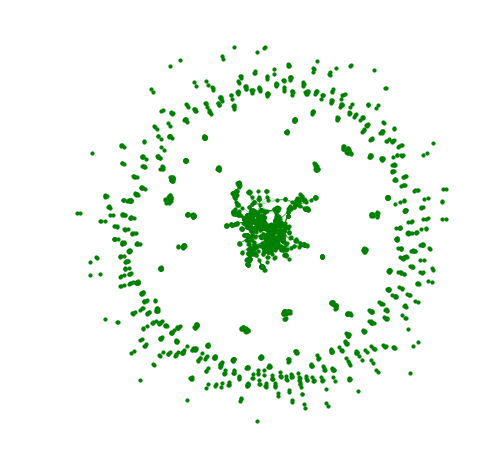

In [7]:
elarge=[(u,v) for (u,v,d) in G.edges(data=True) if d['weight'] >10]
esmall=[(u,v) for (u,v,d) in G.edges(data=True) if d['weight'] <=10]
pos = nx.spring_layout(G)
plt.figure(figsize=(8, 8))
nx.draw_networkx_nodes(G,pos,node_size=10, node_color='g')
nx.draw_networkx_edges(G,pos,edgelist=elarge, width=5, edge_color='k')
nx.draw_networkx_edges(G,pos,edgelist=esmall, width=0.5,alpha=0.5,edge_color='g')
plt.axis('off')
plt.axis('equal')

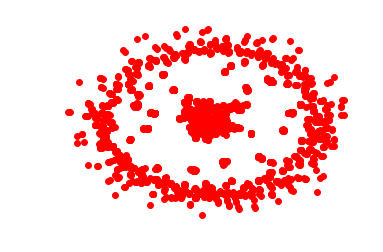

In [8]:
plt.axis("off")
nx.draw_networkx(G, pos = pos, with_labels = False, node_size = 35)

In [9]:
def partitions(nodes, n):
    "Partitions the nodes into n subsets"
    nodes_iter = iter(nodes)
    while True:
        partition = tuple(itertools.islice(nodes_iter,n))
        if not partition:
            return
        yield partition

In [10]:
def btwn_pool(G_tuple):
    return nx.betweenness_centrality_source(*G_tuple)

In [11]:
def between_parallel(G, processes = None):
    p = Pool(processes=processes)
    part_generator = 4*len(p._pool)
    node_partitions = list(partitions(G.nodes(), int(len(G)/part_generator)))
    num_partitions = len(node_partitions)
 
    bet_map = p.map(btwn_pool,
                        zip([G]*num_partitions,
                        [True]*num_partitions,
                        [None]*num_partitions,
                        node_partitions))
 
    bt_c = bet_map[0]
    for bt in bet_map[1:]:
        for n in bt:
            bt_c[n] += bt[n]
    return bt_c

In [12]:
bt = between_parallel(G)
top = 10

max_nodes =  sorted(bt.items(), key = lambda v: -v[1])[:top]
print(max_nodes)

[('Lomakin, Vitaliy', 0.04927322097048186), ('Wang, Hao', 0.04855769792416015), ('Park, Jihoon', 0.047079202985810184), ('Fullerton, E. E.', 0.04666979219171247), ('Schabes, Manfred', 0.043965545648550125), ('Weller, Dieter', 0.03686335955018814), ('Wood, Roger', 0.032329578265207735), ('Chen, Yunjie', 0.03168382268096549), ('Piramanayagam, S. N.', 0.024365564840089397), ('Yang, H.', 0.02414705988032803)]


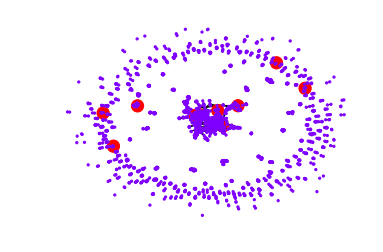

In [13]:
bt_values = [5]*len(G.nodes())
bt_colors = [0]*len(G.nodes())
for i in range(len(max_nodes)):
    bt_values[i] = 150
    bt_colors[i] = 2

plt.axis("off")
nx.draw_networkx(G, pos = pos, cmap = plt.get_cmap("rainbow"), node_color = bt_colors, node_size = bt_values, with_labels = False)

In [14]:
parts = community.best_partition(G)
values = [parts.get(node) for node in G.nodes()]

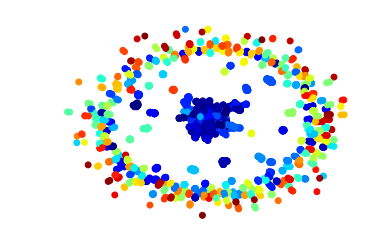

In [15]:
plt.axis("off")
nx.draw_networkx(G, pos = pos, cmap = plt.get_cmap("jet"), node_color = values, node_size = 35, with_labels = False)